
**Deep Fundamental Factor Modeling**

In this notebook, we present our findings from the **WRDS monthly fin_ratio dataset** using the factor sensitivity approach by Dixon et al. We calculate the relative importance of these factors by training an MLP and using the Jacobian matrix as a metric of sensitivity. Next, we use the variables with much higher importance as an input to our backtester and use the future 1 month returns to predict cumulative returns.

Authors: Amit Pawar, Tadbhagya Kumar \\
Original paper: [Dixon et al.](https://arxiv.org/pdf/1903.07677.pdf)


# Prelim Data analysis

In [ ]:
import tensorflow as tf
import scipy as spy 
import numpy as np
# !pip install eli5
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The cleaned dataset is available as a gzip file, final_data.gz that can be loaded directly
df = pd.read_pickle('/content/drive/My Drive/Project_Bank/Data/final_data.gz', compression = 'gzip')
df.index = df['public_date']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1080127 entries, 1980-01-31 to 2020-01-31
Data columns (total 68 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   public_date     1080127 non-null  datetime64[ns]
 1   gvkey           1080127 non-null  int64         
 2   iid             1080127 non-null  object        
 3   tic             1080127 non-null  object        
 4   ajexm           1080127 non-null  float32       
 5   prccm           1080127 non-null  float32       
 6   trt1m           1080127 non-null  float32       
 7   cshom           1080127 non-null  float32       
 8   adj_prccm       1080127 non-null  float32       
 9   adj_cshom       1080127 non-null  float32       
 10  fut_1m_r        1080127 non-null  float32       
 11  1yr_ret_vol     1080127 non-null  float64       
 12  CAPEI           1080127 non-null  float32       
 13  bm              1080127 non-null  float32       
 14  evm

Text(0, 0.5, '# of companies')

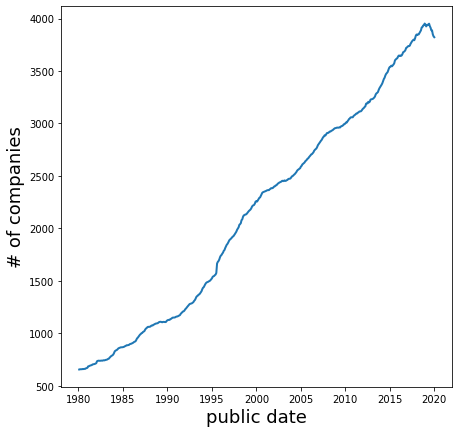

In [ ]:
# Here we look at the cross section of the dataset, no. of companies(datadate) 
dates = pd.date_range(start='1980-01-31',end='2019-12-31',freq='M')
num_gvkeys = []
for date in dates:
    dat = df.loc[date]
    num_gvkeys.append(dat['gvkey'].nunique())

plt.figure(figsize=(7,7))
plt.plot(np.array(dates),num_gvkeys,linewidth=2)
plt.xlabel('public date',fontsize=18)
plt.ylabel('# of companies',fontsize=18)

# Network definition and training

In [ ]:
# Network definition to simplify repeated calls 
class Network(object):
  """ Define the network here """

  def __init__(self,num_layers = None,num_cells = None,actvn = None,input_shape= None):
    """
    Constructor to initialize the model
    """

    self.model = tf.keras.models.Sequential()
    self.model.add(tf.keras.Input(shape=(input_shape,)))
    initializer = tf.keras.initializers.GlorotNormal()


    # Add neurons in each layer
    for i in range(num_layers):
      self.model.add(tf.keras.layers.Dense(num_cells[i], activation = actvn, kernel_initializer=initializer))
      self.model.add(layers.Dropout(0.5))
    
    self.model.add(layers.Dense(1))
    #self.model.summary()

  
  def runMe(self,x_train=None,y_train=None,isVal = True,epochs= None, callbacks = None):
    """
    Perform train/validation split, define training params, perform training
    and report metrics 
    """
    es = EarlyStopping(monitor='val_mse', mode='min', verbose=0, patience=7)
    if x_train is not None:
      
      self.model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=["mse"])
      
      self.model.fit(x_train,y_train,epochs=epochs,verbose=0, batch_size = 100, validation_data = (X_test, y_test), callbacks = [es])

Once the network is trained, we look at the sensitivity of the output (**fut_1m_return**) to the input features. Here, we neglect the sector codes in the initial analysis. Once the output is availabale, the Jacobian $J$ can be computed as

\begin{equation}
J = 
\begin{bmatrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_2}{\partial x_1} & \dots & \frac{\partial y_n}{\partial x_1} \\
\frac{\partial y_1}{\partial x_2} & \frac{\partial y_2}{\partial x_2} & \dots & \frac{\partial y_n}{\partial x_2} \\
\vdots & \vdots & \ddots & \vdots \\
 \frac{\partial y_1}{\partial x_m} & \frac{\partial y_2}{\partial x_m}& \dots & \frac{\partial y_n}{\partial x_m}
\end{bmatrix}
\end{equation}


The sensitivities can then be calculated by summing each row of the Jacobian, which in our implementation is done using **autograd** library, which performs automatic diffrentiation using the network definition.

In [ ]:
#Takes around 8-10 minutes on TPU
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
import autograd.numpy as anp
from autograd import jacobian

def ffpass_anp(x):
    a1 = anp.dot(x, w1) + b1   # affine
    a1 = anp.tanh(a1)    # tanh
    a2 = anp.dot(a1, w2) + b2   # affine
    a2 = anp.tanh(a2)
    a3 = anp.dot(a2, w3) + b3   # affine
    a3 = anp.tanh(a3)
    
    out = anp.dot(a3,w4) +b4
    return out

def jacobian_autograd(x):

    return jacobian(ffpass_anp)(x)

def Sort_Tuples(merged):  
    merged.sort(key = lambda x: x[1], reverse = True)  
    return merged

out_sample_error = []
# define the network parameters here
num_hLayer = 3
num_hCells = [50, 50, 50]
actvn = 'tanh'
input_shape = 23#X_train.shape[1]

dates = list(df['public_date'].unique())
dates = [str(i)[:10] for i in dates]
store_rank = []

for i in range(len(dates)-1):
# for i in range(300,480):
    # Test-train split and network calls
    X_train, y_train = df[dates[i]].iloc[:, 11:34], df[dates[i]].iloc[:, 6]
    X_test, y_test = df[dates[i+1]].iloc[:, 11:34], df[dates[i+1]].iloc[:, 6]
    X_train = (X_train - X_train.mean())/X_train.std()
    X_test = (X_test - X_train.mean())/X_train.std()

    # The parameters can be set at the top of the cell
    f = Network(num_hLayer,num_hCells,actvn,input_shape)
    f.runMe(X_train, y_train, isVal = False, epochs=100)
    y_hat = f.model.predict(X_test)
    mse = mean_squared_error(y_test, y_hat, squared = False)
    out_sample_error.append(mse)

    # we could probably use a better way to write this part
    w1 = f.model.layers[0].get_weights()[0]
    w2 = f.model.layers[2].get_weights()[0]
    w3 = f.model.layers[4].get_weights()[0]
    w4 = f.model.layers[6].get_weights()[0]
    b1 = f.model.layers[0].get_weights()[1]
    b2 = f.model.layers[2].get_weights()[1]
    b3 = f.model.layers[4].get_weights()[1]
    b4 = f.model.layers[6].get_weights()[1]

    J = jacobian_autograd(X_train.values)
    J_avg = np.mean(J,axis=0, keepdims=True)
    J_avg = J_avg.reshape((X_train.shape[0],X_train.shape[1]))
    Sens = np.mean(J_avg,axis=0)

    merged = list(zip(X_train.columns, list(Sens)))
    store_rank.append(Sort_Tuples(merged)[:10])
    if i%50 == 0:
      print(i)


In [ ]:
# here, we take the global ranks from the list and convert them into probabilites
global_factor = []
probs= []
for i in store_rank:

  # separate the factors from values and assemble in list
  # factor = []
  for elem in i:
    global_factor.append(elem[0])

  # append to global list
for i in X_train.columns:
  probs.append([i,global_factor.count(i)/300])

prob_df = pd.DataFrame(probs,columns = ['factor','probability'])
prob_df.sort_values('probability',ascending=False)

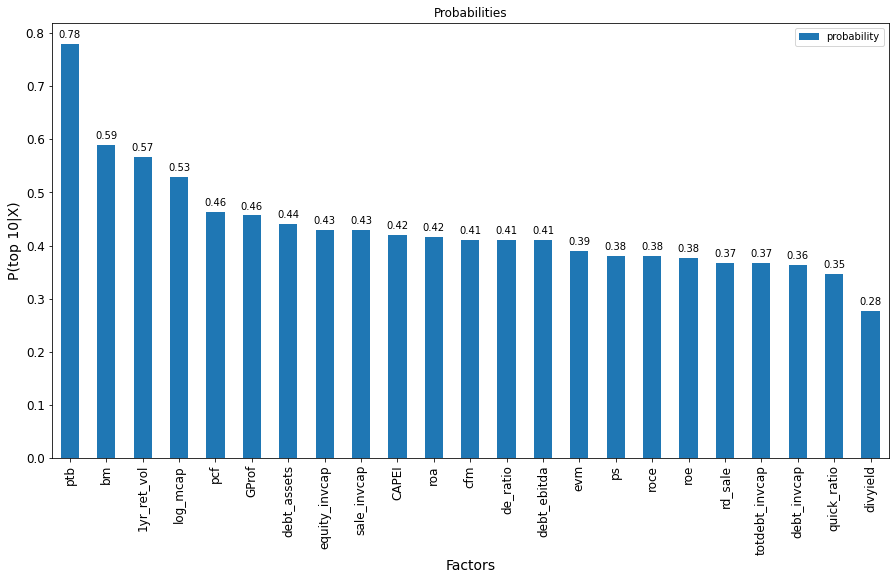

In [ ]:
# Since we've alrady saved the pickle file, we can load it directly
probs = pd.read_pickle('/content/drive/My Drive/Project_Bank/Data/probs_300.pkl')
probs = probs.sort_values('probability',ascending=False)
ax = probs.plot(kind='bar', title = "Probabilities", figsize=(15,8), legend=True, fontsize=12)
ax.set_xlabel("Factors", fontsize=14)
ax.set_ylabel("P(top 10|X)", fontsize=14)
ax.set_xticklabels(probs.factor)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,5))

ax2 = ax1.twinx()
ax1.plot(out_sample_error, color = 'b', lw = 2, label = 'out-sample mse NN')

## Backtesting factors and comparison with random portfolios



In [ ]:
df['mix'] = (0.78*df['ptb'] - 0.59*df['bm'] + 0.57*df['1yr_ret_vol'])/0.76

In [ ]:
# We create a list of indices to select stocks from a sorted Dataframe

idx_long_only = [i for i in range(15)]
idx_short_only = [i for i in range(-15,0)]
idx_long_short = idx_long_only + idx_short_only

In [ ]:
np.random.seed(42)

dates = list(df['public_date'].unique())
tics = []
returns = []
for date in dates[-181:]: 
  port = df[df['public_date'] == date].sort_values('mix', ascending = True)
  port_long_short = port.iloc[idx_long_short, [3,10]]
  random = list(np.random.randint(0, len(port),size = 30))
  port_random_long_short = port.iloc[random, [3,10]]
  tic = list(port['tic'].unique())
  tics.append(tic)
  port_long_short['fut_1m_r'][-15:] = port_long_short['fut_1m_r'][-15:]*(-1)
  ret = port_long_short['fut_1m_r'].sum()/30
  port_random_long_short['fut_1m_r'][-15:] = port_random_long_short['fut_1m_r'][-15:]*(-1)
  rets_rand = port_random_long_short['fut_1m_r'].sum()/30
  returns.append([ret, rets_rand])

returns = pd.DataFrame(returns, index = dates[-181:], columns=['rets', 'rets_random'])
returns['cum_rets'] = (returns['rets'] + 1).cumprod()
returns['cum_rets_random'] = (returns['rets_random'] + 1).cumprod()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


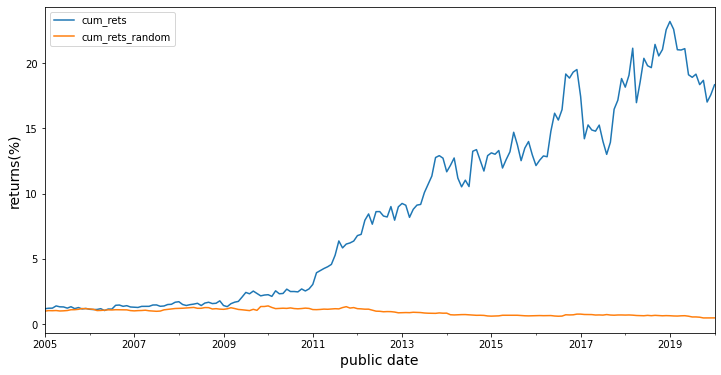

In [ ]:
ax1 = returns[['cum_rets','cum_rets_random']].plot(subplots = False,figsize= (12,6))
plt.xlabel("public date", fontsize=14)
plt.ylabel("returns(%)", fontsize=14)
plt.show()

## Comparison with S&P 500

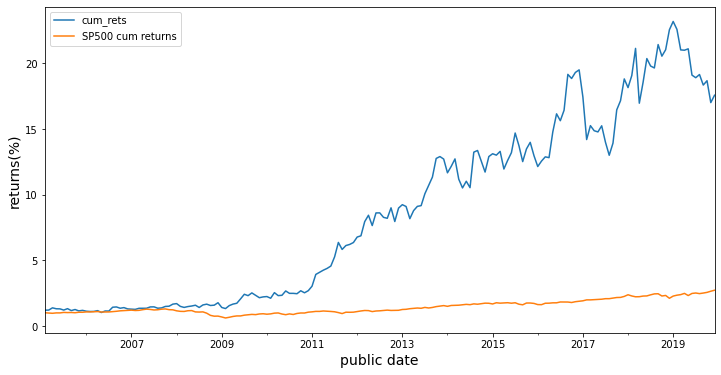

In [ ]:
import pandas_datareader.data as web

data = web.get_data_yahoo('^GSPC','01/01/2005','31/12/2019', interval='m')[['Adj Close', 'Close']]


data['SP500returns'] = data['Adj Close'].pct_change()
data['SP500 cum returns'] = (data['SP500returns'] + 1).cumprod()
data.head()

data.index = returns.index[:-1]

df_with_sp500 = pd.concat([returns.iloc[:-1, :], data], axis = 1).dropna()

ax1 = df_with_sp500[['cum_rets','SP500 cum returns']].plot(subplots = False,figsize= (12,6))
plt.xlabel("public date", fontsize=14)
plt.ylabel("returns(%)", fontsize=14)
plt.show()

In [ ]:
df_with_sp500['excess_rets'] = df_with_sp500['rets'] - df_with_sp500['SP500returns']
info_ratio = df_with_sp500['excess_rets'].mean()/df_with_sp500['excess_rets'].std()
info_ratio

0.13910051337148666